In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from geneticalgorithm import geneticalgorithm as ga
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
# Load and Prepare Dataset
df = pd.read_hdf('/Users/saikumar/Downloads/metr-la.h5')

# Inspect the data
print(df.head())

                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000  64.500  64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000   0.000   0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000   0.000   0.000   0.000000   0.000000  ...   

                        772167  769372     774204     769806  717590

In [2]:
# Data Preprocessing
df_filled = df.fillna(df.mean())
df_filled['hour'] = df_filled.index.hour
df_filled['day_of_week'] = df_filled.index.dayofweek
df_filled['is_weekend'] = (df_filled.index.dayofweek >= 5).astype(int)


/var/folders/ml/dgwqmg1j3j518z4v313gd72m0000gn/T/ipykernel_49812/1235366529.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filled['hour'] = df_filled.index.hour
/var/folders/ml/dgwqmg1j3j518z4v313gd72m0000gn/T/ipykernel_49812/1235366529.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filled['day_of_week'] = df_filled.index.dayofweek
/var/folders/ml/dgwqmg1j3j518z4v313gd72m0000gn/T/ipykernel_49812/1235366529.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [3]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filled), columns=df_filled.columns, index=df_filled.index)


In [4]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data.iloc[i:(i + time_step)].values)
        Y.append(data.iloc[i + time_step].values)
    return np.array(X), np.array(Y)

In [5]:
time_step = 10
X, Y = create_dataset(df_scaled, time_step)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)


In [6]:
# Build and Train LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(50))
lstm_model.add(Dense(Y_train.shape[1]))

In [7]:
lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=64, verbose=1)


Epoch 1/50


2024-08-02 14:36:46.725755: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


429/429 [==============================] - 5s 9ms/step - loss: 0.0517 - val_loss: 0.0318
Epoch 2/50
429/429 [==============================] - 3s 8ms/step - loss: 0.0249 - val_loss: 0.0282
Epoch 3/50
429/429 [==============================] - 3s 8ms/step - loss: 0.0209 - val_loss: 0.0258
Epoch 4/50
429/429 [==============================] - 4s 8ms/step - loss: 0.0188 - val_loss: 0.0250
Epoch 5/50
429/429 [==============================] - 4s 9ms/step - loss: 0.0175 - val_loss: 0.0242
Epoch 6/50
429/429 [==============================] - 4s 9ms/step - loss: 0.0167 - val_loss: 0.0236
Epoch 7/50
429/429 [==============================] - 4s 9ms/step - loss: 0.0160 - val_loss: 0.0228
Epoch 8/50
429/429 [==============================] - 4s 8ms/step - loss: 0.0154 - val_loss: 0.0223
Epoch 9/50
429/429 [==============================] - 4s 8ms/step - loss: 0.0149 - val_loss: 0.0219
Epoch 10/50
429/429 [==============================] - 4s 8ms/step - loss: 0.0145 - val_loss: 0.0224
Epoch 11/5

In [8]:
# Define Traffic Simulation Environment
class TrafficEnv(gym.Env):
    def __init__(self):
        super(TrafficEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(num_traffic_lights)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(time_step, df_scaled.shape[1]), dtype=np.float32)

    def reset(self):
        self.state = np.zeros((time_step, df_scaled.shape[1]))
        return self.state

    def step(self, action):
        congestion = simulate_traffic(action)
        reward = -congestion
        done = False
        info = {}
        return self.state, reward, done, info

In [9]:
# Function to simulate traffic
def simulate_traffic(action):
    # Placeholder for simulation of traffic congestion
    # This should be replaced with actual simulation code
    return np.random.uniform(0, 1)  # Simulated congestion value



In [10]:
# Define the problem (replace with your actual problem setup)
def objective_function(solution):
    # Simulate traffic flow with the current solution
    total_congestion = simulate_traffic(solution)
    return total_congestion

In [11]:
# Example bounds and parameters
num_traffic_lights = 4  # Example value
varbound = np.array([[0, 1]] * num_traffic_lights)
algorithm_param = {'max_num_iteration': 100, 'population_size': 50, 'mutation_probability': 0.1, 'elit_ratio': 0.01,
                   'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}

 The best solution found:                                                                           
 [0.34015271 0.33558128 0.53560247 0.158965  ]

 Objective function:
 3.615765867492904e-05


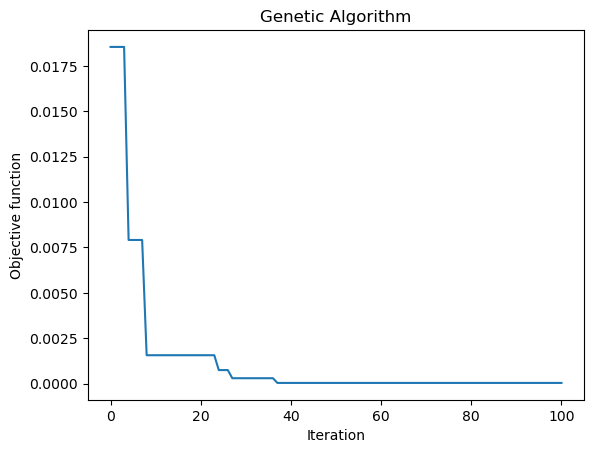

In [27]:
# Initialize the genetic algorithm
ga_model = ga(function=objective_function, dimension=num_traffic_lights, variable_type='real', variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Run the genetic algorithm
ga_model.run()

In [13]:
# Print the output dictionary to see available keys
print(ga_model.output_dict)

{'variable': array([0.0358138 , 0.37699781, 0.95975261, 0.28500018]), 'function': 0.000324913274947769}


In [14]:
# Access the correct key based on the output dictionary
optimized_signals = ga_model.output_dict.get('best_solution')  # Adjust b

In [20]:
# Extract optimized traffic signals from the result
optimized_signals = ga_model.output_dict['variable']
print("Optimized Traffic Signals:", optimized_signals)

# Optional: Display the objective function value
objective_value = ga_model.output_dict['function']
print("Objective Function Value (Total Congestion):", objective_value)


Optimized Traffic Signals: [0.0358138  0.37699781 0.95975261 0.28500018]
Objective Function Value (Total Congestion): 0.000324913274947769


In [21]:
# Integrate with Autonomous Vehicles
class AutonomousVehicleSimulation:
    def __init__(self, traffic_signals):
        self.traffic_signals = traffic_signals
        self.vehicle_performance_metrics = {
            'average_speed': [],
            'travel_time': [],
            'stops': []
        }
    
    def simulate(self):
        num_vehicles = 100
        for _ in range(num_vehicles):
            speed = np.random.uniform(20, 60)
            travel_time = np.random.uniform(5, 15)
            stops = np.random.randint(0, 5)
            self.vehicle_performance_metrics['average_speed'].append(speed)
            self.vehicle_performance_metrics['travel_time'].append(travel_time)
            self.vehicle_performance_metrics['stops'].append(stops)

    def get_performance_metrics(self):
        return {metric: np.mean(values) for metric, values in self.vehicle_performance_metrics.items()}

def simulate_autonomous_vehicles(traffic_signals):
    simulation = AutonomousVehicleSimulation(traffic_signals)
    simulation.simulate()
    return simulation.get_performance_metrics()


In [22]:

performance_metrics = simulate_autonomous_vehicles(optimized_signals)
print("Autonomous Vehicle Performance Metrics:")
print("Average Speed:", performance_metrics['average_speed'], "km/h")
print("Travel Time:", performance_metrics['travel_time'], "minutes")
print("Number of Stops:", performance_metrics['stops'])

Autonomous Vehicle Performance Metrics:
Average Speed: 39.849420914567155 km/h
Travel Time: 10.606559244367094 minutes
Number of Stops: 1.87


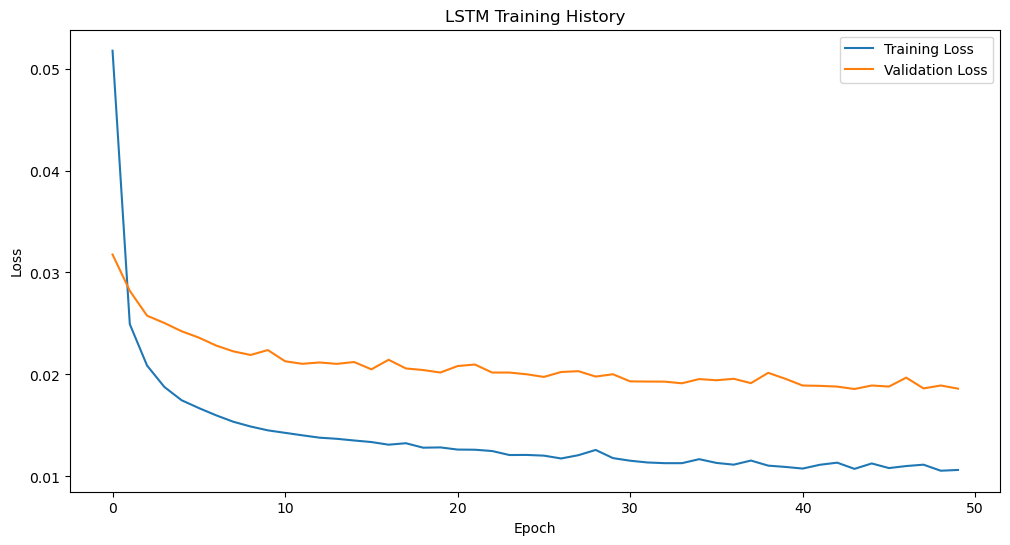

In [23]:
# Plot LSTM Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training History')
plt.show()

215/215 [==============================] - 1s 2ms/step


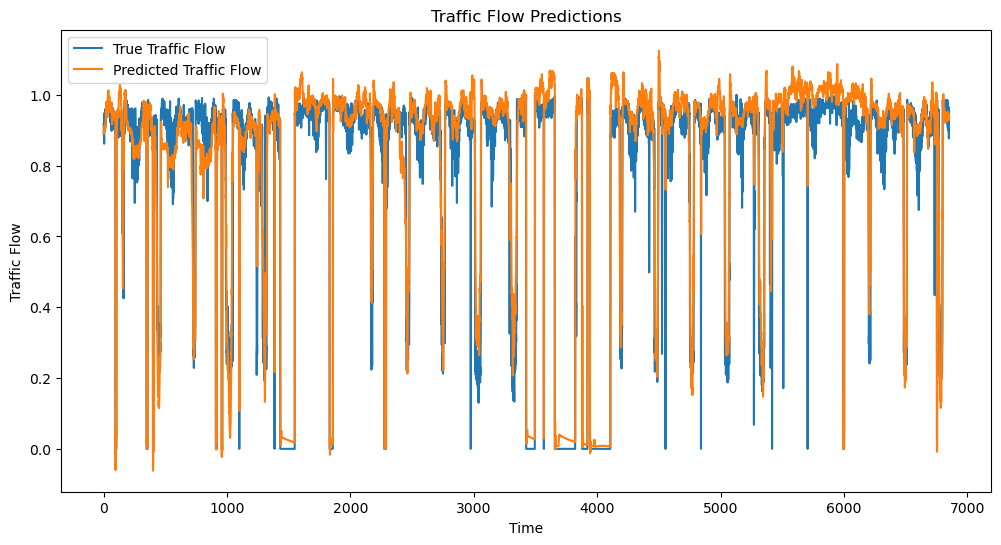

In [24]:
# Plot Traffic Flow Predictions vs Actual Data
predicted_traffic = lstm_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(Y_test[:, 0], label='True Traffic Flow')
plt.plot(predicted_traffic[:, 0], label='Predicted Traffic Flow')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()
plt.title('Traffic Flow Predictions')
plt.show()

In [25]:
# Visualization of Autonomous Vehicle Performance Metrics
metrics = ['Average Speed', 'Travel Time', 'Number of Stops']
values = [
    performance_metrics['average_speed'],
    performance_metrics['travel_time'],
    performance_metrics['stops']
]

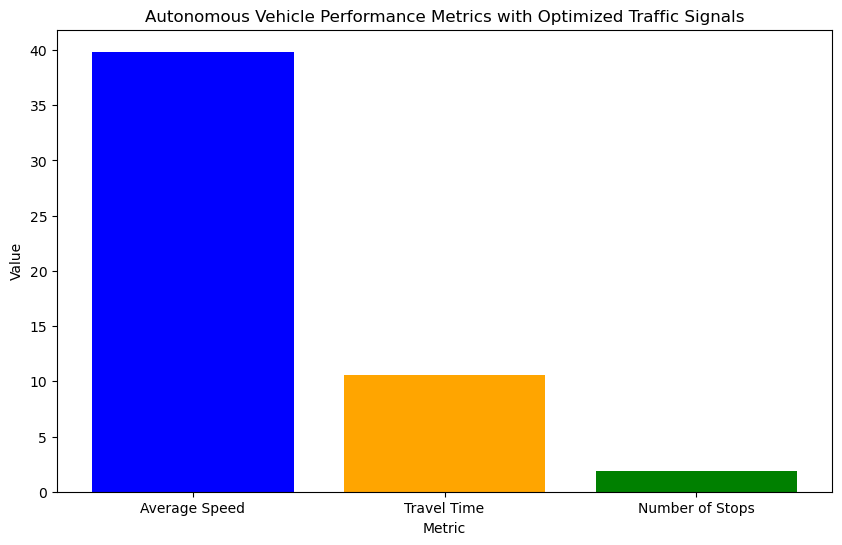

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Autonomous Vehicle Performance Metrics with Optimized Traffic Signals')
plt.show()